---
title: "Lab 8 - Linear Classifiers"
author: "Tyler Allen"
date: "2024-12-02"
format:
  html:
    cold-fold: true
    embed-resources: true
theme: "lux"
---

**Part One: Binary Classification**

Create a dataset that is limited only to the Sativa and Indica type cannabis strains.


In [85]:
import pandas as pd
data = pd.read_csv('cannabis_full.csv')
df = data.loc[(data['Type'] == 'sativa') | (data['Type'] == 'indica')]
df.dropna(inplace=True)
df.head()

<ipython-input-85-d85c56977bf9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet",0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,5Th-Element,indica,4.4,"Relaxed,Focused,Euphoric,Uplifted,Aroused","Earthy,Woody,Pine",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

This section asks you to create a final best model for each of the four new model types studied this week: LDA, QDA, SVC, and SVM. For SVM, you may limit yourself to only the polynomial kernel.

For each, you should:

Choose a metric you will use to select your model, and briefly justify your choice. (Hint: There is no specific target category here, so this should not be a metric that only prioritizes one category.)

Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

Report the (cross-validated!) metric.

Fit the final model.

Output a confusion matrix.

*Q1: LDA*

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#for the non-numeric columns
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object', 'category']).columns:
    df[column] = label_encoder.fit_transform(df[column].astype(str))

X = df.drop(columns=['Type'])  #drop target column
y = df['Type']  #target variable

#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#used ChatGPT here because my CV accuracy scores were so high and it had me add stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#parameter grid
param_grid = {
    'solver': ['svd', 'lsqr'],  #used ChatGPT here
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]  #and here
}

#filtering invalid combinations
param_grid_filtered = [
    {'solver': ['svd']},  #and here
    {'solver': ['lsqr'], 'shrinkage': ['auto', 0.1, 0.5, 0.9]}  #and here
]

#lda and grid search
lda = LinearDiscriminantAnalysis()
grid_search = GridSearchCV(lda, param_grid_filtered, cv=5, scoring='accuracy', error_score='raise')

grid_search.fit(X_train, y_train)

#best parameters and accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")

Best parameters: {'shrinkage': 0.9, 'solver': 'lsqr'}
Best cross-validated accuracy: 0.8594


I chose accuracy because I figured the dataset was pretty balanced and there isn't a need to focus on minimizing false positives or false negatives.

In [40]:
#fitting final model
best_lda = grid_search.best_estimator_
best_lda.fit(X_train, y_train)

#cf
y_pred_best_lda = best_lda.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lda))

Confusion Matrix:
[[183  15]
 [ 17 106]]


In [39]:
print("Classification Report:")
print(classification_report(y_test, y_pred_best_lda))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       198
           1       0.88      0.86      0.87       123

    accuracy                           0.90       321
   macro avg       0.90      0.89      0.89       321
weighted avg       0.90      0.90      0.90       321



*Q2: QDA*



In [47]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#was getting warnings about collinearity, so I consulted ChatGPT here and it recommended using PCA
#learned that PCA reduces redundancy caused by highly correlated features by combining them into fewer independent components, thus reducing collinearity
pipeline = Pipeline([
    ('pca', PCA()),  #pca
    ('qda', QuadraticDiscriminantAnalysis()) #qda
])

param_grid = {
    'pca__n_components': [5, 10, 15, 20],  #number of principal components to keep
    'qda__reg_param': [0.1, 0.2, 0.5, 0.9, 1.0]  # Regularization for QDA
}

#grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)

#best parameters and accuracy score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")

Best parameters: {'pca__n_components': 15, 'qda__reg_param': 1.0}
Best cross-validated accuracy: 0.8593


Chose to focus on accuracy here as well for the same reason I explained earlier.

In [51]:
#using best pipeline
best_pipeline = grid_search.best_estimator_
y_pred_pca = best_pipeline.predict(X_test)

#cf
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pca))

Confusion Matrix:
[[178  20]
 [ 16 107]]


In [50]:
print("Classification Report:")
print(classification_report(y_test, y_pred_pca))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       198
           1       0.84      0.87      0.86       123

    accuracy                           0.89       321
   macro avg       0.88      0.88      0.88       321
weighted avg       0.89      0.89      0.89       321



*Q3: SVC*


In [58]:
from sklearn.svm import SVC

#missed this day of class, so I got some help here too
param_grid_svc = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], #kernel types
    'C': [0.1, 1, 10, 100], #regularization strength
    'gamma': ['scale', 'auto'], #kernel coefficient
    'degree': [2, 3, 4]  #degree of the polynomial kernel
}

#svc with polynomial kernel
svc = SVC()

#gridsearchCV for hyperparameter tuning
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy', error_score='raise')
grid_search_svc.fit(X_train, y_train)

#best parameters and accuracy
print(f"Best parameters for SVC: {grid_search_svc.best_params_}")
print(f"Best cross-validated accuracy for SVC: {grid_search_svc.best_score_:.4f}")

Best parameters for Polynomial SVC: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validated accuracy for Polynomial SVC: 0.8393


I chose accuracy to focus on for the same reasons as before.

In [59]:
#fitting final model
best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test)

#cf
print("SVC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svc))

SVC Confusion Matrix:
[[185  13]
 [ 24  99]]


In [60]:
print("SVC Classification Report:")
print(classification_report(y_test, y_pred_svc))

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       198
           1       0.88      0.80      0.84       123

    accuracy                           0.88       321
   macro avg       0.88      0.87      0.88       321
weighted avg       0.88      0.88      0.88       321



*Q4: SVM*

In [62]:
#parameter grid for SVM with a polynomial kernel
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4, 5]
}

#svm with a polynomial kernel
svm_poly = SVC(kernel='poly')  #svm classifier with polynomial kernel

#gridsearchCV for hyperparameter tuning
grid_search_svm = GridSearchCV(svm_poly, param_grid_svm, cv=5, scoring='accuracy', error_score='raise')
grid_search_svm.fit(X_train, y_train)

print(f"Best parameters for Polynomial SVM: {grid_search_svm.best_params_}")
print(f"Best cross-validated accuracy for Polynomial SVM: {grid_search_svm.best_score_:.4f}")

Best parameters for Polynomial SVM: {'C': 10, 'degree': 3, 'gamma': 'scale'}
Best cross-validated accuracy for Polynomial SVM: 0.8179


Chose accuracy for the same reasons as before.

In [63]:
#fitting final model
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

#cf
print("Polynomial SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Polynomial SVM Confusion Matrix:
[[179  19]
 [ 34  89]]


In [65]:
print("Polynomial SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

Polynomial SVM Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       198
           1       0.82      0.72      0.77       123

    accuracy                           0.83       321
   macro avg       0.83      0.81      0.82       321
weighted avg       0.83      0.83      0.83       321



The best model for predicting the Type variable based on accuracy score was the LDA model with parameters {'shrinkage': 0.9, 'solver': 'lsqr'} which had an accuracy score of 0.8594. It is worth noting that the QDA model with parameters {'pca__n_components': 15, 'qda__reg_param': 1.0} had an accuracy score of 0.8593.

**Part Two: Natural Multiclass**

Now use the full dataset, including the Hybrid strains.



In [98]:
data.dropna(inplace=True)
data.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,0,0,4.0,48,517,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16,0,4.7,806,592,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,4.4,1550,975,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0,4.2,1396,17,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,0,4.6,603,190,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Q1:
Fit a decision tree, plot the final fit, and interpret the results.


In [87]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

X = data.drop(columns=['Type', 'Strain'])  #dropping the target and non-predictive columns
y = data['Type']

#encode categorical columns
X_encoded = pd.get_dummies(X)

#encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  #encoding 'hybrid', 'sativa', 'indica' as integers

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

#decision tree
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42)  #can tune max_depth
decision_tree.fit(X_train, y_train)

#predicting on test set
y_pred = decision_tree.predict(X_test)

#cf
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[265  53  46]
 [ 85 122   3]
 [ 79   9  44]]


In [88]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

      hybrid       0.62      0.73      0.67       364
      indica       0.66      0.58      0.62       210
      sativa       0.47      0.33      0.39       132

    accuracy                           0.61       706
   macro avg       0.58      0.55      0.56       706
weighted avg       0.60      0.61      0.60       706



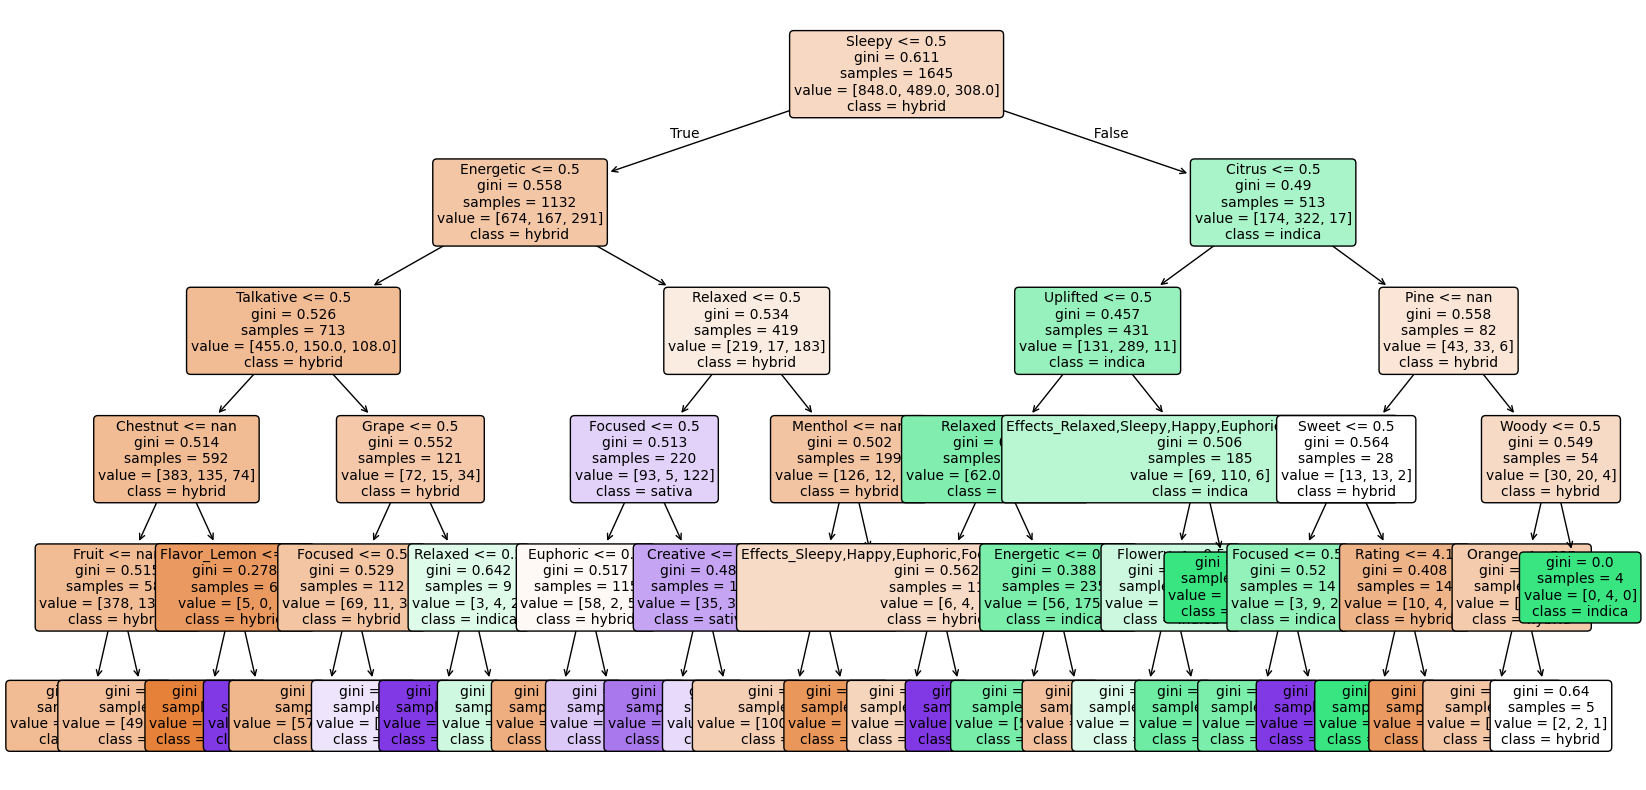

In [89]:
#plot of decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    decision_tree,
    feature_names=X_encoded.columns,
    class_names=label_encoder.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

To start, I can see from this decision tree that the features Sleepy, Energetic, Citrus, Talkative, and Relaxed are the most important features at the top of the tree. The first split is based on Sleepy, which indiciates that this feature is most influential in classfying between hybrid, sativa, and indica strains. The value at this split [848.0, 489.0, 308,0] followed by class=hybrid shows that 848 samples are hybrid, 489 are indica, and 308 are sativa and if you were to predict the strain at this node, the predicted strain would be hybrid. With the color scheming to show the strains, I can see that strains Sleepy > 0.5 and Citrus > 0.5 are more likely to be indica and strains with Sleepy <= 0.5 and Energetic <= 0.5 are more likely to be hybrid.


Q2:
Repeat the analyses from Part One for LDA, QDA, and KNN.



In [91]:
#LDA
#for the non-numeric columns
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object', 'category']).columns:
    data[column] = label_encoder.fit_transform(data[column].astype(str))

X = data.drop(columns=['Type'])  #drop target column
y = data['Type']  #target variable

#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#used ChatGPT here because my CV accuracy scores were so high and it had me add stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#parameter grid
param_grid = {
    'solver': ['svd', 'lsqr'],  #used ChatGPT here
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]  #and here
}

#filtering invalid combinations
param_grid_filtered = [
    {'solver': ['svd']},  #and here
    {'solver': ['lsqr'], 'shrinkage': ['auto', 0.1, 0.5, 0.9]}  #and here
]

#lda and grid search
lda = LinearDiscriminantAnalysis()
grid_search = GridSearchCV(lda, param_grid_filtered, cv=5, scoring='accuracy', error_score='raise')

grid_search.fit(X_train, y_train)

#best parameters and accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")

Best parameters: {'shrinkage': 0.1, 'solver': 'lsqr'}
Best cross-validated accuracy: 0.6438


In [92]:
#fitting final model
best_lda = grid_search.best_estimator_
best_lda.fit(X_train, y_train)

#cf
y_pred_best_lda = best_lda.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lda))

Confusion Matrix:
[[221  67  49]
 [ 65 127   6]
 [ 74   9  40]]


In [93]:
print("Classification Report:")
print(classification_report(y_test, y_pred_best_lda))

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.66      0.63       337
           1       0.63      0.64      0.63       198
           2       0.42      0.33      0.37       123

    accuracy                           0.59       658
   macro avg       0.55      0.54      0.54       658
weighted avg       0.58      0.59      0.58       658



In [94]:
#QDA
pipeline = Pipeline([
    ('pca', PCA()),  #pca
    ('qda', QuadraticDiscriminantAnalysis()) #qda
])

param_grid = {
    'pca__n_components': [5, 10, 15, 20],  #number of principal components to keep
    'qda__reg_param': [0.1, 0.2, 0.5, 0.9, 1.0]  # Regularization for QDA
}

#grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)

#best parameters and accuracy score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")

Best parameters: {'pca__n_components': 20, 'qda__reg_param': 1.0}
Best cross-validated accuracy: 0.6360


In [95]:
#using best pipeline
best_pipeline = grid_search.best_estimator_
y_pred_pca = best_pipeline.predict(X_test)

#cf
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pca))

Confusion Matrix:
[[205  77  55]
 [ 65 127   6]
 [ 60   9  54]]


In [96]:
print("Classification Report:")
print(classification_report(y_test, y_pred_pca))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.61       337
           1       0.60      0.64      0.62       198
           2       0.47      0.44      0.45       123

    accuracy                           0.59       658
   macro avg       0.56      0.56      0.56       658
weighted avg       0.59      0.59      0.59       658



In [102]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

#scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)  #standardize

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

#parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9], #different numbers of neighbors
    'weights': ['uniform', 'distance'], #uniform or distance-based weighting
    'p': [1, 2] #distance metric: 1=Manhattan, 2=Euclidean
}

knn = KNeighborsClassifier()

#gridsearchCV for hyperparameter tuning
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', error_score='raise')
grid_search_knn.fit(X_train, y_train)

#best parameters and accuracy score
print(f"Best parameters for KNN: {grid_search_knn.best_params_}")
print(f"Best cross-validated accuracy for KNN: {grid_search_knn.best_score_:.4f}")

Best parameters for KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best cross-validated accuracy for KNN: 0.4371


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [103]:
#predicting on the test set
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

KNN Confusion Matrix:
[[121 204  12]
 [ 47 149   2]
 [ 47  67   9]]


In [107]:
#converting target names to strings
target_names = [str(cls) for cls in label_encoder.classes_]
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=target_names))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.36      0.44       337
           1       0.35      0.75      0.48       198
           2       0.39      0.07      0.12       123

    accuracy                           0.42       658
   macro avg       0.44      0.39      0.35       658
weighted avg       0.47      0.42      0.39       658



Q3:
Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

The metrics performed much worse than in Part One because of the introduction of the Hybrid class. It is much easier for models to differentiate between two distinct categories than three, especially when the Hybrid class has similar characteristics to both Indica and Sativa.

Furthermore, Hybrid was the most common misclassified class as shown from the 3 confussion matrices. This is likely due to its overlapping characteristics with the other two types. Also, since hybrid is the most common type, it is possible that the models overpredicted it.

**Part Three: Multiclass from Binary**

Consider two models designed for binary classification: SVC and Logistic Regression.

Q1:
Fit and report metrics for OvR versions of the models. That is, for each of the two model types, create three models:

Indica vs. Not Indica

Sativa vs. Not Sativa

Hybrid vs. Not Hybrid


In [109]:
from sklearn.preprocessing import LabelBinarizer

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

#make target variable binary for OvR classification
label_binarizer = LabelBinarizer()
y_binarized = label_binarizer.fit_transform(y_encoded)  #this creates separate binary labels for each class

In [117]:
#svc for indica vs. not indica (1 vs. others)
y_binary_indica = (y_encoded == 1).astype(int)  #1 for indica, 0 for others

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary_indica, test_size=0.3, random_state=42, stratify=y_binary_indica
)

#train SVC
svc_indica = SVC(kernel='linear', random_state=42)
svc_indica.fit(X_train, y_train)

#results
y_pred = svc_indica.predict(X_test)
print("SVC: Indica vs. Not Indica")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

SVC: Indica vs. Not Indica
Confusion Matrix:
[[384  76]
 [ 91 107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       460
           1       0.58      0.54      0.56       198

    accuracy                           0.75       658
   macro avg       0.70      0.69      0.69       658
weighted avg       0.74      0.75      0.74       658



In [116]:
#svc for sativa vs. not sativa (2 vs. others)
y_binary_sativa = (y_encoded == 2).astype(int)  #1 for sativa, 0 for others

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary_sativa, test_size=0.3, random_state=42, stratify=y_binary_sativa
)

#train SVC
svc_sativa = SVC(kernel='linear', random_state=42)
svc_sativa.fit(X_train, y_train)

#results
y_pred = svc_sativa.predict(X_test)
print("SVC: Sativa vs. Not Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVC: Sativa vs. Not Sativa
Confusion Matrix:
[[506  29]
 [105  18]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       535
           1       0.38      0.15      0.21       123

    accuracy                           0.80       658
   macro avg       0.61      0.55      0.55       658
weighted avg       0.74      0.80      0.76       658



In [115]:
#svc for hybrid vs. not hybrid (0 vs. others)
y_binary_hybrid = (y_encoded == 0).astype(int)  #1 for hybrid, 0 for others

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary_hybrid, test_size=0.3, random_state=42, stratify=y_binary_hybrid
)

#train SVC
svc_hybrid = SVC(kernel='linear', random_state=42)
svc_hybrid.fit(X_train, y_train)

#results
y_pred = svc_hybrid.predict(X_test)
print("SVC: Hybrid vs. Not Hybrid")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVC: Hybrid vs. Not Hybrid
Confusion Matrix:
[[150 171]
 [127 210]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.47      0.50       321
           1       0.55      0.62      0.58       337

    accuracy                           0.55       658
   macro avg       0.55      0.55      0.54       658
weighted avg       0.55      0.55      0.54       658



In [121]:
#log reg for indica vs. not indica (1 vs. others)
y_binary_indica = (y_encoded == 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary_indica, test_size=0.3, random_state=42, stratify=y_binary_indica
)

#train log reg
log_reg_indica = LogisticRegression(random_state=42, max_iter=1000)
log_reg_indica.fit(X_train, y_train)

#results
y_pred = log_reg_indica.predict(X_test)
print("Logistic Regression: Indica vs. Not Indica")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression: Indica vs. Not Indica
Confusion Matrix:
[[411  49]
 [ 98 100]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       460
           1       0.67      0.51      0.58       198

    accuracy                           0.78       658
   macro avg       0.74      0.70      0.71       658
weighted avg       0.77      0.78      0.77       658



In [119]:
#log reg for sativa vs. not sativa (2 vs. others)
y_binary_sativa = (y_encoded == 2).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary_sativa, test_size=0.3, random_state=42, stratify=y_binary_sativa
)

#train log reg
log_reg_sativa = LogisticRegression(random_state=42, max_iter=1000)
log_reg_sativa.fit(X_train, y_train)

#results
y_pred = log_reg_sativa.predict(X_test)
print("Logistic Regression: Sativa vs. Not Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression: Sativa vs. Not Sativa
Confusion Matrix:
[[516  19]
 [111  12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       535
           1       0.39      0.10      0.16       123

    accuracy                           0.80       658
   macro avg       0.61      0.53      0.52       658
weighted avg       0.74      0.80      0.75       658



In [122]:
#log reg for hybrid vs. not hybrid (0 vs. others)
y_binary_hybrid = (y_encoded == 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary_hybrid, test_size=0.3, random_state=42, stratify=y_binary_hybrid
)

#train log reg
log_reg_hybrid = LogisticRegression(random_state=42, max_iter=1000)
log_reg_hybrid.fit(X_train, y_train)

#results
y_pred = log_reg_hybrid.predict(X_test)
print("Logistic Regression: Hybrid vs. Not Hybrid")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression: Hybrid vs. Not Hybrid
Confusion Matrix:
[[166 155]
 [130 207]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       321
           1       0.57      0.61      0.59       337

    accuracy                           0.57       658
   macro avg       0.57      0.57      0.57       658
weighted avg       0.57      0.57      0.57       658



Q2:
Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?



The models that were run sativa vs non sativa did the best job at distinguishing the target category from the rest, while the models with hybrid vs non hybrid did the worst. Intuitively, this makes sense because sativa strains typically have more distinct characteristics, while hybrid characteristics are much more ambiguous.

Q3:
Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:

Indica vs. Sativa

Indica vs. Hybrid

Hybrid vs. Sativa


In [124]:
#svc indica (1) vs. sativa (0)
#subset for indica (1) vs. sativa (2)
mask = (y_encoded == 1) | (y_encoded == 2)
X_pair = X_scaled[mask]
y_pair = y_encoded[mask]
y_pair = (y_pair == 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_pair, y_pair, test_size=0.3, random_state=42, stratify=y_pair
)

#train SVC
svc_indica_sativa = SVC(kernel='linear', random_state=42)
svc_indica_sativa.fit(X_train, y_train)

#results
y_pred = svc_indica_sativa.predict(X_test)
print("SVC: Indica vs. Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVC: Indica vs. Sativa
Confusion Matrix:
[[ 82  41]
 [ 14 184]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       123
           1       0.82      0.93      0.87       198

    accuracy                           0.83       321
   macro avg       0.84      0.80      0.81       321
weighted avg       0.83      0.83      0.82       321



In [125]:
#svc for indica (1) vs. hybrid (0)
mask = (y_encoded == 1) | (y_encoded == 0)
X_pair = X_scaled[mask]
y_pair = y_encoded[mask]
y_pair = (y_pair == 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_pair, y_pair, test_size=0.3, random_state=42, stratify=y_pair
)

#train SVC
svc_indica_hybrid = SVC(kernel='linear', random_state=42)
svc_indica_hybrid.fit(X_train, y_train)

#results
y_pred = svc_indica_hybrid.predict(X_test)
print("SVC: Indica vs. Hybrid")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVC: Indica vs. Hybrid
Confusion Matrix:
[[281  56]
 [104  94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       337
           1       0.63      0.47      0.54       198

    accuracy                           0.70       535
   macro avg       0.68      0.65      0.66       535
weighted avg       0.69      0.70      0.69       535



In [126]:
#svc for hybrid (1) vs. sativa (0)
mask = (y_encoded == 0) | (y_encoded == 2)
X_pair = X_scaled[mask]
y_pair = y_encoded[mask]
y_pair = (y_pair == 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_pair, y_pair, test_size=0.3, random_state=42, stratify=y_pair
)

#train SVC
svc_hybrid_sativa = SVC(kernel='linear', random_state=42)
svc_hybrid_sativa.fit(X_train, y_train)

#results
y_pred = svc_hybrid_sativa.predict(X_test)
print("SVC: Hybrid vs. Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVC: Hybrid vs. Sativa
Confusion Matrix:
[[ 19 104]
 [ 18 319]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.15      0.24       123
           1       0.75      0.95      0.84       337

    accuracy                           0.73       460
   macro avg       0.63      0.55      0.54       460
weighted avg       0.69      0.73      0.68       460



In [128]:
#log reg for indica (1) vs. sativa (0)
mask = (y_encoded == 1) | (y_encoded == 2)
X_pair = X_scaled[mask]
y_pair = y_encoded[mask]
y_pair = (y_pair == 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_pair, y_pair, test_size=0.3, random_state=42, stratify=y_pair
)

#train log reg
log_reg_indica_sativa = LogisticRegression(random_state=42, max_iter=1000)
log_reg_indica_sativa.fit(X_train, y_train)

#results
y_pred = log_reg_indica_sativa.predict(X_test)
print("Logistic Regression: Indica vs. Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression: Indica vs. Sativa
Confusion Matrix:
[[ 77  46]
 [ 11 187]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.63      0.73       123
           1       0.80      0.94      0.87       198

    accuracy                           0.82       321
   macro avg       0.84      0.79      0.80       321
weighted avg       0.83      0.82      0.81       321



In [129]:
#log reg for indica (1) vs. hybrid (0)
mask = (y_encoded == 1) | (y_encoded == 0)
X_pair = X_scaled[mask]
y_pair = y_encoded[mask]
y_pair = (y_pair == 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_pair, y_pair, test_size=0.3, random_state=42, stratify=y_pair
)

#train log reg
log_reg_indica_hybrid = LogisticRegression(random_state=42, max_iter=1000)
log_reg_indica_hybrid.fit(X_train, y_train)

#results
y_pred = log_reg_indica_hybrid.predict(X_test)
print("Logistic Regression: Indica vs. Hybrid")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression: Indica vs. Hybrid
Confusion Matrix:
[[292  45]
 [116  82]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.78       337
           1       0.65      0.41      0.50       198

    accuracy                           0.70       535
   macro avg       0.68      0.64      0.64       535
weighted avg       0.69      0.70      0.68       535



In [131]:
#log reg for sativa (1) vs. hybrid (0)
mask = (y_encoded == 2) | (y_encoded == 0)
X_pair = X_scaled[mask]
y_pair = y_encoded[mask]
y_pair = (y_pair == 2).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_pair, y_pair, test_size=0.3, random_state=42, stratify=y_pair
)

#train log reg
log_reg_sativa_hybrid = LogisticRegression(random_state=42, max_iter=1000)
log_reg_sativa_hybrid.fit(X_train, y_train)

#results
y_pred = log_reg_sativa_hybrid.predict(X_test)
print("Logistic Regression: Sativa vs. Hybrid")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression: Sativa vs. Hybrid
Confusion Matrix:
[[315  22]
 [111  12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.83       337
           1       0.35      0.10      0.15       123

    accuracy                           0.71       460
   macro avg       0.55      0.52      0.49       460
weighted avg       0.64      0.71      0.65       460




Q4:
Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?



The models that had indica vs sativa performed the best, and this makes sense since they are strains with opposite characteristics. The models with indica vs hybrid did the worst, and this makes sense because those two likely share more characteristics with each other than they do sativa.

Q5:
Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach?

What about for SVC?

If I had simply input the full data with all three classes into the LogisticRegression function, it would have automatically taken an OvR approach. If I did the same for SVC, it would automatically take an OvO approach.